## 2013テニス勝敗予測

In [1]:
import pandas as pd
import numpy as np
## 可視化
import matplotlib.pyplot as plt 
import seaborn as sns
# 前処理
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
#モデリング
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")
#日本語表示
import japanize_matplotlib

##  1 分析設定
- 試合の結果（プレーヤー1が勝った場合=1,プレーヤー2が勝った場合=0）
- 目的変数　：Result (0 or 1)2値分類
- 評価指標　：Accuracy
- 0:men     1:women

- UFE : Unforced Error(自分がミスした回数)
- WNR : Winner（ウィナー）の数」＝プレーヤー1が打った決まったショットの本数

In [2]:
import pandas as pd

# 表示設定だけ変更（戻り値なし）
pd.set_option('display.max_columns', 100)

# 表示したいDataFrameに対して head() を使

df_train = pd.read_csv('./data/train.tsv', sep='\t')
print(df_train.shape)
df_train.head()

(471, 46)


,id,Tournament,Sex,Year,Player1,Player2,Round,Result,FNL.1,FNL.2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,0,FrenchOpen,men,2013,Jarkko Nieminen,Paul-Henri Mathieu,1,1,3,2,69,84,31,29,11.0,4.0,57.0,42.0,6,7,8.0,13.0,172.0,6,4.0,7.0,4.0,6.0,54,58,46,36,7.0,8.0,60.0,71.0,5,15,24.0,33.0,163.0,4,6.0,6.0,6.0,2.0
1,3,AusOpen,women,2013,Varvara Lepchenko,Simona Halep,2,0,1,2,63,34,37,10,1.0,4.0,23.0,47.0,2,2,9.0,10.0,66.0,6,0.0,1.0,NaN,NaN,58,29,42,16,0.0,3.0,10.0,19.0,6,15,1.0,2.0,90.0,4,6.0,6.0,NaN,NaN
2,4,Wimbledon,women,2013,H.Watson,M.Keys,1,0,0,2,53,18,47,13,4.0,2.0,11.0,15.0,5,2,7.0,4.0,NaN,3,5.0,NaN,NaN,NaN,63,25,37,10,8.0,2.0,23.0,18.0,7,5,8.0,5.0,NaN,6,7.0,NaN,NaN,NaN
3,7,USOpen,women,2013,S Williams,F Schiavone,1,1,2,0,51,13,49,12,1.0,0.0,13.0,8.0,9,6,8.0,6.0,NaN,6,6.0,NaN,NaN,NaN,43,8,57,5,0.0,8.0,3.0,18.0,0,0,6.0,3.0,NaN,0,1.0,NaN,NaN,NaN
4,9,AusOpen,women,2013,Tadeja Majeric,Ajla Tomljanovic,1,0,1,2,72,54,28,10,4.0,7.0,4.0,7.0,3,6,NaN,NaN,99.0,6,6.0,4.0,NaN,NaN,49,36,51,25,5.0,6.0,5.0,6.0,3,6,NaN,NaN,97.0,3,7.0,6.0,NaN,NaN


In [3]:
df_test = pd.read_csv('./data/test.tsv', sep='\t')
print(df_test.shape)
df_test.head()

(472, 45)


,id,Tournament,Sex,Year,Player1,Player2,Round,FNL.1,FNL.2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,1,Wimbledon,women,2013,A.Radwanska,M.Keys,3,2.0,1.0,71,55,29,18,2.0,1.0,23.0,10.0,18.0,3.0,31.0,20.0,NaN,7.0,4.0,6.0,NaN,NaN,61,53,39,16,15.0,1.0,67.0,51.0,10.0,2.0,34.0,22.0,NaN,5.0,6.0,3.0,NaN,NaN
1,2,AusOpen,men,2013,Nick Kyrgios,Benjamin Becker,1,3.0,1.0,54,60,46,25,34.0,13.0,71.0,52.0,6.0,8.0,5.0,8.0,133.0,6.0,6.0,6.0,7.0,NaN,53,45,47,31,12.0,5.0,38.0,36.0,3.0,7.0,6.0,6.0,114.0,3.0,7.0,2.0,6.0,NaN
2,5,Wimbledon,men,2013,V.Pospisil,M.Youzhny,2,2.0,3.0,63,83,37,25,26.0,2.0,66.0,27.0,7.0,2.0,61.0,39.0,NaN,2.0,7.0,6.0,6.0,4.0,64,76,36,39,8.0,2.0,53.0,20.0,7.0,4.0,46.0,32.0,NaN,6.0,6.0,7.0,3.0,6.0
3,6,FrenchOpen,women,2013,Caroline Wozniacki,Bojana Jovanovski,2,0.0,2.0,70,29,30,10,1.0,3.0,13.0,18.0,2.0,3.0,5.0,7.0,62.0,6.0,3.0,NaN,NaN,NaN,68,34,32,8,3.0,1.0,33.0,32.0,3.0,7.0,2.0,5.0,72.0,7.0,6.0,NaN,NaN,NaN
4,8,Wimbledon,men,2013,N.Djokovic,J.Chardy,3,3.0,0.0,74,40,26,12,8.0,1.0,38.0,3.0,16.0,5.0,21.0,18.0,NaN,6.0,6.0,6.0,NaN,NaN,66,32,34,15,6.0,4.0,18.0,14.0,0.0,0.0,23.0,12.0,NaN,3.0,2.0,2.0,NaN,NaN


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 46 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          471 non-null    int64  
 1   Tournament  471 non-null    object 
 2   Sex         471 non-null    object 
 3   Year        471 non-null    int64  
 4   Player1     471 non-null    object 
 5   Player2     471 non-null    object 
 6   Round       471 non-null    int64  
 7   Result      471 non-null    int64  
 8   FNL.1       471 non-null    int64  
 9   FNL.2       471 non-null    int64  
 10  FSP.1       471 non-null    int64  
 11  FSW.1       471 non-null    int64  
 12  SSP.1       471 non-null    int64  
 13  SSW.1       471 non-null    int64  
 14  ACE.1       462 non-null    float64
 15  DBF.1       468 non-null    float64
 16  WNR.1       408 non-null    float64
 17  UFE.1       408 non-null    float64
 18  BPC.1       471 non-null    int64  
 19  BPW.1       471 non-null    i

## カテゴリ変数確認

In [5]:
df_train["Result"].value_counts()

Result
0    247
1    224
Name: count, dtype: int64

In [6]:
df_train["Tournament"].value_counts()

Tournament
AusOpen       132
Wimbledon     122
FrenchOpen    120
USOpen         97
Name: count, dtype: int64

In [7]:
df_train["Sex"].value_counts()

Sex
men      256
women    215
Name: count, dtype: int64

In [8]:
df_train["Player1"].value_counts()

Player1
Stanislas Wawrinka    9
Novak Djokovic        7
Rafael Nadal          6
Na Li                 6
Benoit Paire          5
                     ..
Steve Darcis          1
L.Safarova            1
K.Anderson            1
E.Baltacha            1
K.Nishikori           1
Name: count, Length: 309, dtype: int64

In [9]:
df_train["Year"].value_counts()

Year
2013    471
Name: count, dtype: int64

## 先にラベルエンコーディングを行う

In [10]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(df_train["Tournament"])
encoder.fit(df_test["Tournament"])

df_train["Tournament"] = encoder.transform(df_train["Tournament"])
df_test["Tournament"] = encoder.transform(df_test["Tournament"])


print("変換結果 : ", encoder.classes_)    # 左から順に0, 1, 2, 3

変換結果 :  ['AusOpen' 'FrenchOpen' 'USOpen' 'Wimbledon']


In [11]:
# LightGBMのためのラベルエンコーディング
encoder = LabelEncoder()
encoder.fit(df_train["Sex"])
encoder.fit(df_test["Sex"])

df_train["Sex"] = encoder.transform(df_train["Sex"])
df_test["Sex"] = encoder.transform(df_test["Sex"])



print("変換結果 : ", encoder.classes_)    # 左から順に0, 1

変換結果 :  ['men' 'women']


In [12]:
df_train.head()

,id,Tournament,Sex,Year,Player1,Player2,Round,Result,FNL.1,FNL.2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,0,1,0,2013,Jarkko Nieminen,Paul-Henri Mathieu,1,1,3,2,69,84,31,29,11.0,4.0,57.0,42.0,6,7,8.0,13.0,172.0,6,4.0,7.0,4.0,6.0,54,58,46,36,7.0,8.0,60.0,71.0,5,15,24.0,33.0,163.0,4,6.0,6.0,6.0,2.0
1,3,0,1,2013,Varvara Lepchenko,Simona Halep,2,0,1,2,63,34,37,10,1.0,4.0,23.0,47.0,2,2,9.0,10.0,66.0,6,0.0,1.0,NaN,NaN,58,29,42,16,0.0,3.0,10.0,19.0,6,15,1.0,2.0,90.0,4,6.0,6.0,NaN,NaN
2,4,3,1,2013,H.Watson,M.Keys,1,0,0,2,53,18,47,13,4.0,2.0,11.0,15.0,5,2,7.0,4.0,NaN,3,5.0,NaN,NaN,NaN,63,25,37,10,8.0,2.0,23.0,18.0,7,5,8.0,5.0,NaN,6,7.0,NaN,NaN,NaN
3,7,2,1,2013,S Williams,F Schiavone,1,1,2,0,51,13,49,12,1.0,0.0,13.0,8.0,9,6,8.0,6.0,NaN,6,6.0,NaN,NaN,NaN,43,8,57,5,0.0,8.0,3.0,18.0,0,0,6.0,3.0,NaN,0,1.0,NaN,NaN,NaN
4,9,0,1,2013,Tadeja Majeric,Ajla Tomljanovic,1,0,1,2,72,54,28,10,4.0,7.0,4.0,7.0,3,6,NaN,NaN,99.0,6,6.0,4.0,NaN,NaN,49,36,51,25,5.0,6.0,5.0,6.0,3,6,NaN,NaN,97.0,3,7.0,6.0,NaN,NaN


## 結果変数となっている者を削除していく
取った総セット数と、2~5セットまでの、総取得ゲーム数など

In [13]:
df_train = df_train.drop(["Player1","Player2","Year","ST2.1","ST3.1","ST4.1","ST5.1","ST2.2","ST3.2","ST4.2","ST5.2","FNL.1","FNL.2","TPW.1","TPW.2","BPW.1", "BPW.2", "BPC.1", "BPC.2"],axis=1)
df_test = df_test.drop(["Player1","Player2","Year","ST2.1","ST3.1","ST4.1","ST5.1","ST2.2","ST3.2","ST4.2","ST5.2","FNL.1","FNL.2","TPW.1","TPW.2","BPW.1", "BPW.2", "BPC.1", "BPC.2"],axis=1)


In [14]:
print(df_train.shape)
print(df_test.shape)

(471, 27)
(472, 26)


## 探索的データ分析

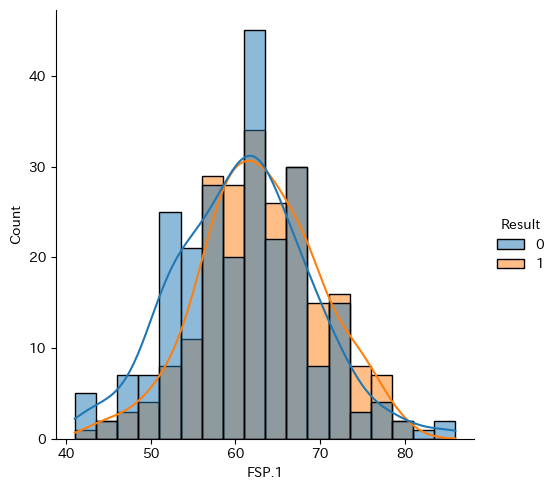

In [30]:
# 年齢の偏り
sns.displot(x = "FSP.1", data = df_train, hue = "Result", kde = True)
plt.show()

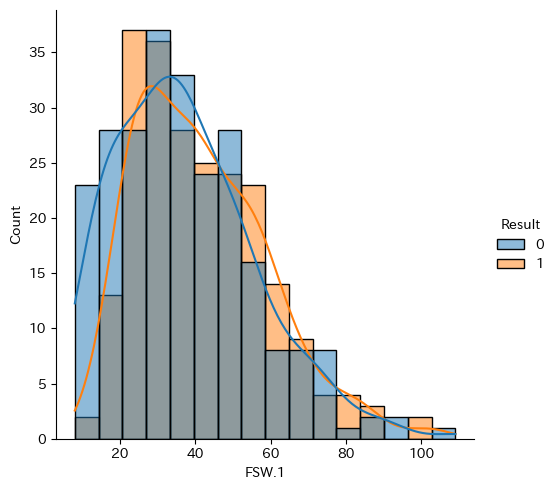

In [31]:
# 年齢の偏り
sns.displot(x = "FSW.1", data = df_train, hue = "Result", kde = True)
plt.show()

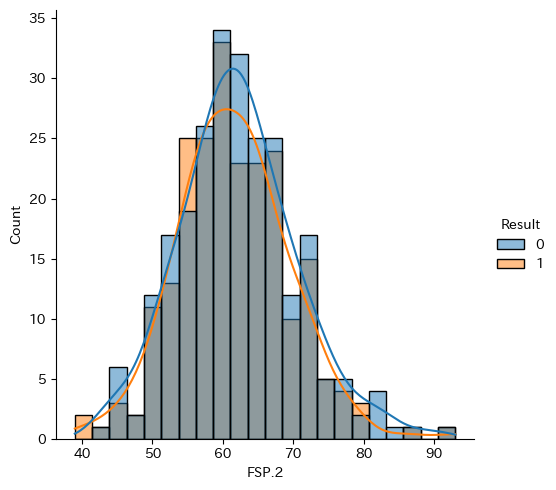

In [32]:
# 年齢の偏り
sns.displot(x = "FSP.2", data = df_train, hue = "Result", kde = True)
plt.show()

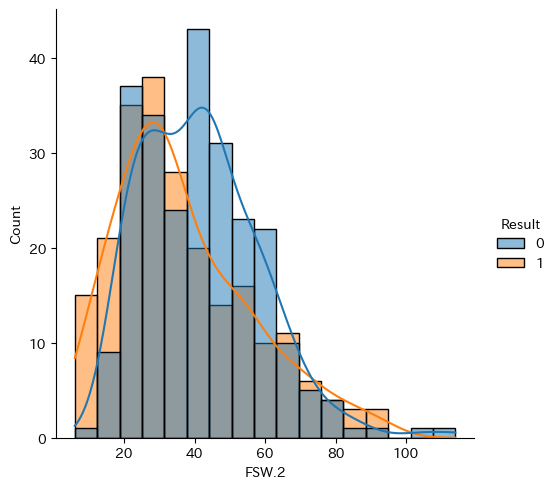

In [33]:
# 年齢の偏り
sns.displot(x = "FSW.2", data = df_train, hue = "Result", kde = True)
plt.show()

In [34]:
# サービスの偏り
pd.crosstab(df_train["FSW.1"], df_train["Result"], margins = "all")

Result,0,1,All
FSW.1,,,
8,2,0,2
9,5,0,5
11,3,0,3
12,6,0,6
13,2,1,3
...,...,...,...
91,1,0,1
92,1,0,1
102,0,2,2


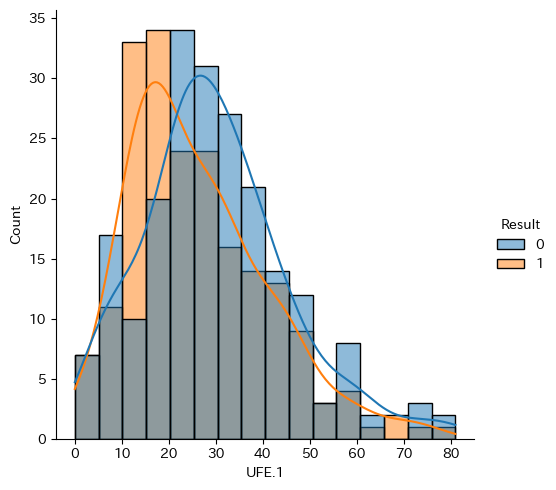

In [35]:
# ミスの少なさ
sns.displot(x = "UFE.1", data = df_train, hue = "Result", kde = True)
plt.show()

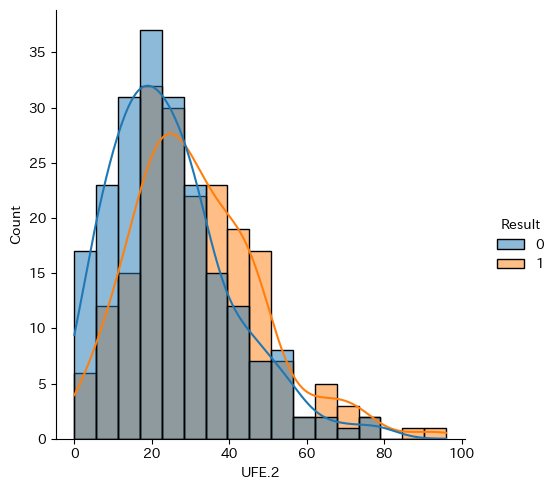

In [36]:
# ミスの数
sns.displot(x = "UFE.2", data = df_train, hue = "Result", kde = True)
plt.show()

## 相関調べ

In [37]:
df_train.corr(numeric_only=True)

,id,Tournament,Sex,Round,Result,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,NPA.1,NPW.1,ST1.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,NPA.2,NPW.2,ST1.2
id,1.000000,0.032681,0.026324,0.016310,0.036545,0.070326,-0.012155,-0.069303,-0.028777,-0.029575,-0.016734,-0.060172,-0.084729,0.031906,0.015667,0.010437,0.055123,-0.020451,-0.055123,-0.057997,-0.074608,-0.060730,-0.035932,-0.029536,-0.053639,-0.053954,-0.038889
Tournament,0.032681,1.000000,0.020721,-0.023650,0.053926,0.038081,0.016964,-0.036858,-0.036954,0.059186,-0.058016,0.100181,-0.250981,0.426614,-0.032335,-0.000614,0.091807,0.002830,-0.091807,-0.051183,0.087174,-0.119074,0.061387,-0.251750,0.360503,-0.054293,-0.023926
Sex,0.026324,0.020721,1.000000,0.138316,0.032002,0.040424,-0.623388,-0.037509,-0.578057,-0.523808,-0.159684,-0.528183,-0.289343,-0.381188,-0.545244,-0.092316,0.082710,-0.625704,-0.082710,-0.588728,-0.518299,-0.128079,-0.511897,-0.281469,-0.397528,-0.529607,-0.101308
Round,0.016310,-0.023650,0.138316,1.000000,0.032233,0.057906,-0.043843,-0.057827,-0.101503,-0.100538,-0.124601,0.074192,0.083465,0.083263,0.010300,0.005874,0.127675,-0.037689,-0.127675,-0.107417,-0.139201,-0.128709,0.033282,0.017535,0.046059,-0.015085,-0.008829
Result,0.036545,0.053926,0.032002,0.032233,1.000000,0.137122,0.123824,-0.134648,0.089538,0.188667,-0.125164,0.267098,-0.118559,0.096210,0.013947,0.544049,-0.042195,-0.131089,0.042195,-0.148765,-0.163972,0.131341,-0.176390,0.213507,-0.013594,-0.011335,-0.549992
FSP.1,0.070326,0.038081,0.040424,0.057906,0.137122,1.000000,0.171742,-0.998174,-0.342178,-0.096414,-0.320941,0.019493,-0.134310,0.081966,0.036912,0.096724,0.098532,-0.015758,-0.098532,-0.104399,-0.038322,-0.079495,0.089376,0.042436,0.101614,0.040523,-0.146124
FSW.1,-0.012155,0.016964,-0.623388,-0.043843,0.123824,0.171742,1.000000,-0.174976,0.743420,0.643606,0.295502,0.763392,0.499964,0.576088,0.650621,0.338280,0.004593,0.877111,-0.004593,0.755984,0.569157,0.279560,0.668599,0.496400,0.557655,0.634979,0.097971
SSP.1,-0.069303,-0.036858,-0.037509,-0.057827,-0.134648,-0.998174,-0.174976,1.000000,0.339875,0.093727,0.319183,-0.022268,0.131145,-0.084003,-0.039280,-0.095200,-0.101225,0.011601,0.101225,0.101003,0.035638,0.076013,-0.093147,-0.042787,-0.101584,-0.042551,0.141100
SSW.1,-0.028777,-0.036954,-0.578057,-0.101503,0.089538,-0.342178,0.743420,0.339875,1.000000,0.582660,0.365055,0.669115,0.485901,0.456406,0.581280,0.273461,-0.055003,0.789000,0.055003,0.719039,0.551571,0.329230,0.569355,0.496577,0.452090,0.601474,0.126951
ACE.1,-0.029575,0.059186,-0.523808,-0.100538,0.188667,-0.096414,0.643606,0.093727,0.582660,1.000000,0.237697,0.729642,0.274917,0.404619,0.411809,0.276706,0.009942,0.602383,-0.009942,0.520773,0.432715,0.152044,0.356392,0.182902,0.286250,0.327694,0.003630


In [38]:
# 相関行列の計算
corr_matrix = df_train.corr(numeric_only=True)

# Resultとの相関を抽出（自分自身との相関を除く）
result_corr = corr_matrix["Result"].drop("Result").sort_values(ascending=False)

# 上位10個を表示（正の相関が強い順）
print("Resultと相関が高い変数 Top10:")
print(result_corr.head(10))



Resultと相関が高い変数 Top10:
ST1.1         0.544049
WNR.1         0.267098
UFE.2         0.213507
ACE.1         0.188667
FSP.1         0.137122
DBF.2         0.131341
FSW.1         0.123824
NPA.1         0.096210
SSW.1         0.089538
Tournament    0.053926
Name: Result, dtype: float64


In [39]:
# 負の相関Top10（絶対値が大きいもの順）
print("Resultと負の相関が強い変数 Top10:")
print(result_corr.sort_values().head(10))


Resultと負の相関が強い変数 Top10:
ST1.2   -0.549992
WNR.2   -0.176390
ACE.2   -0.163972
SSW.2   -0.148765
SSP.1   -0.134648
FSW.2   -0.131089
DBF.1   -0.125164
UFE.1   -0.118559
FSP.2   -0.042195
NPA.2   -0.013594
Name: Result, dtype: float64


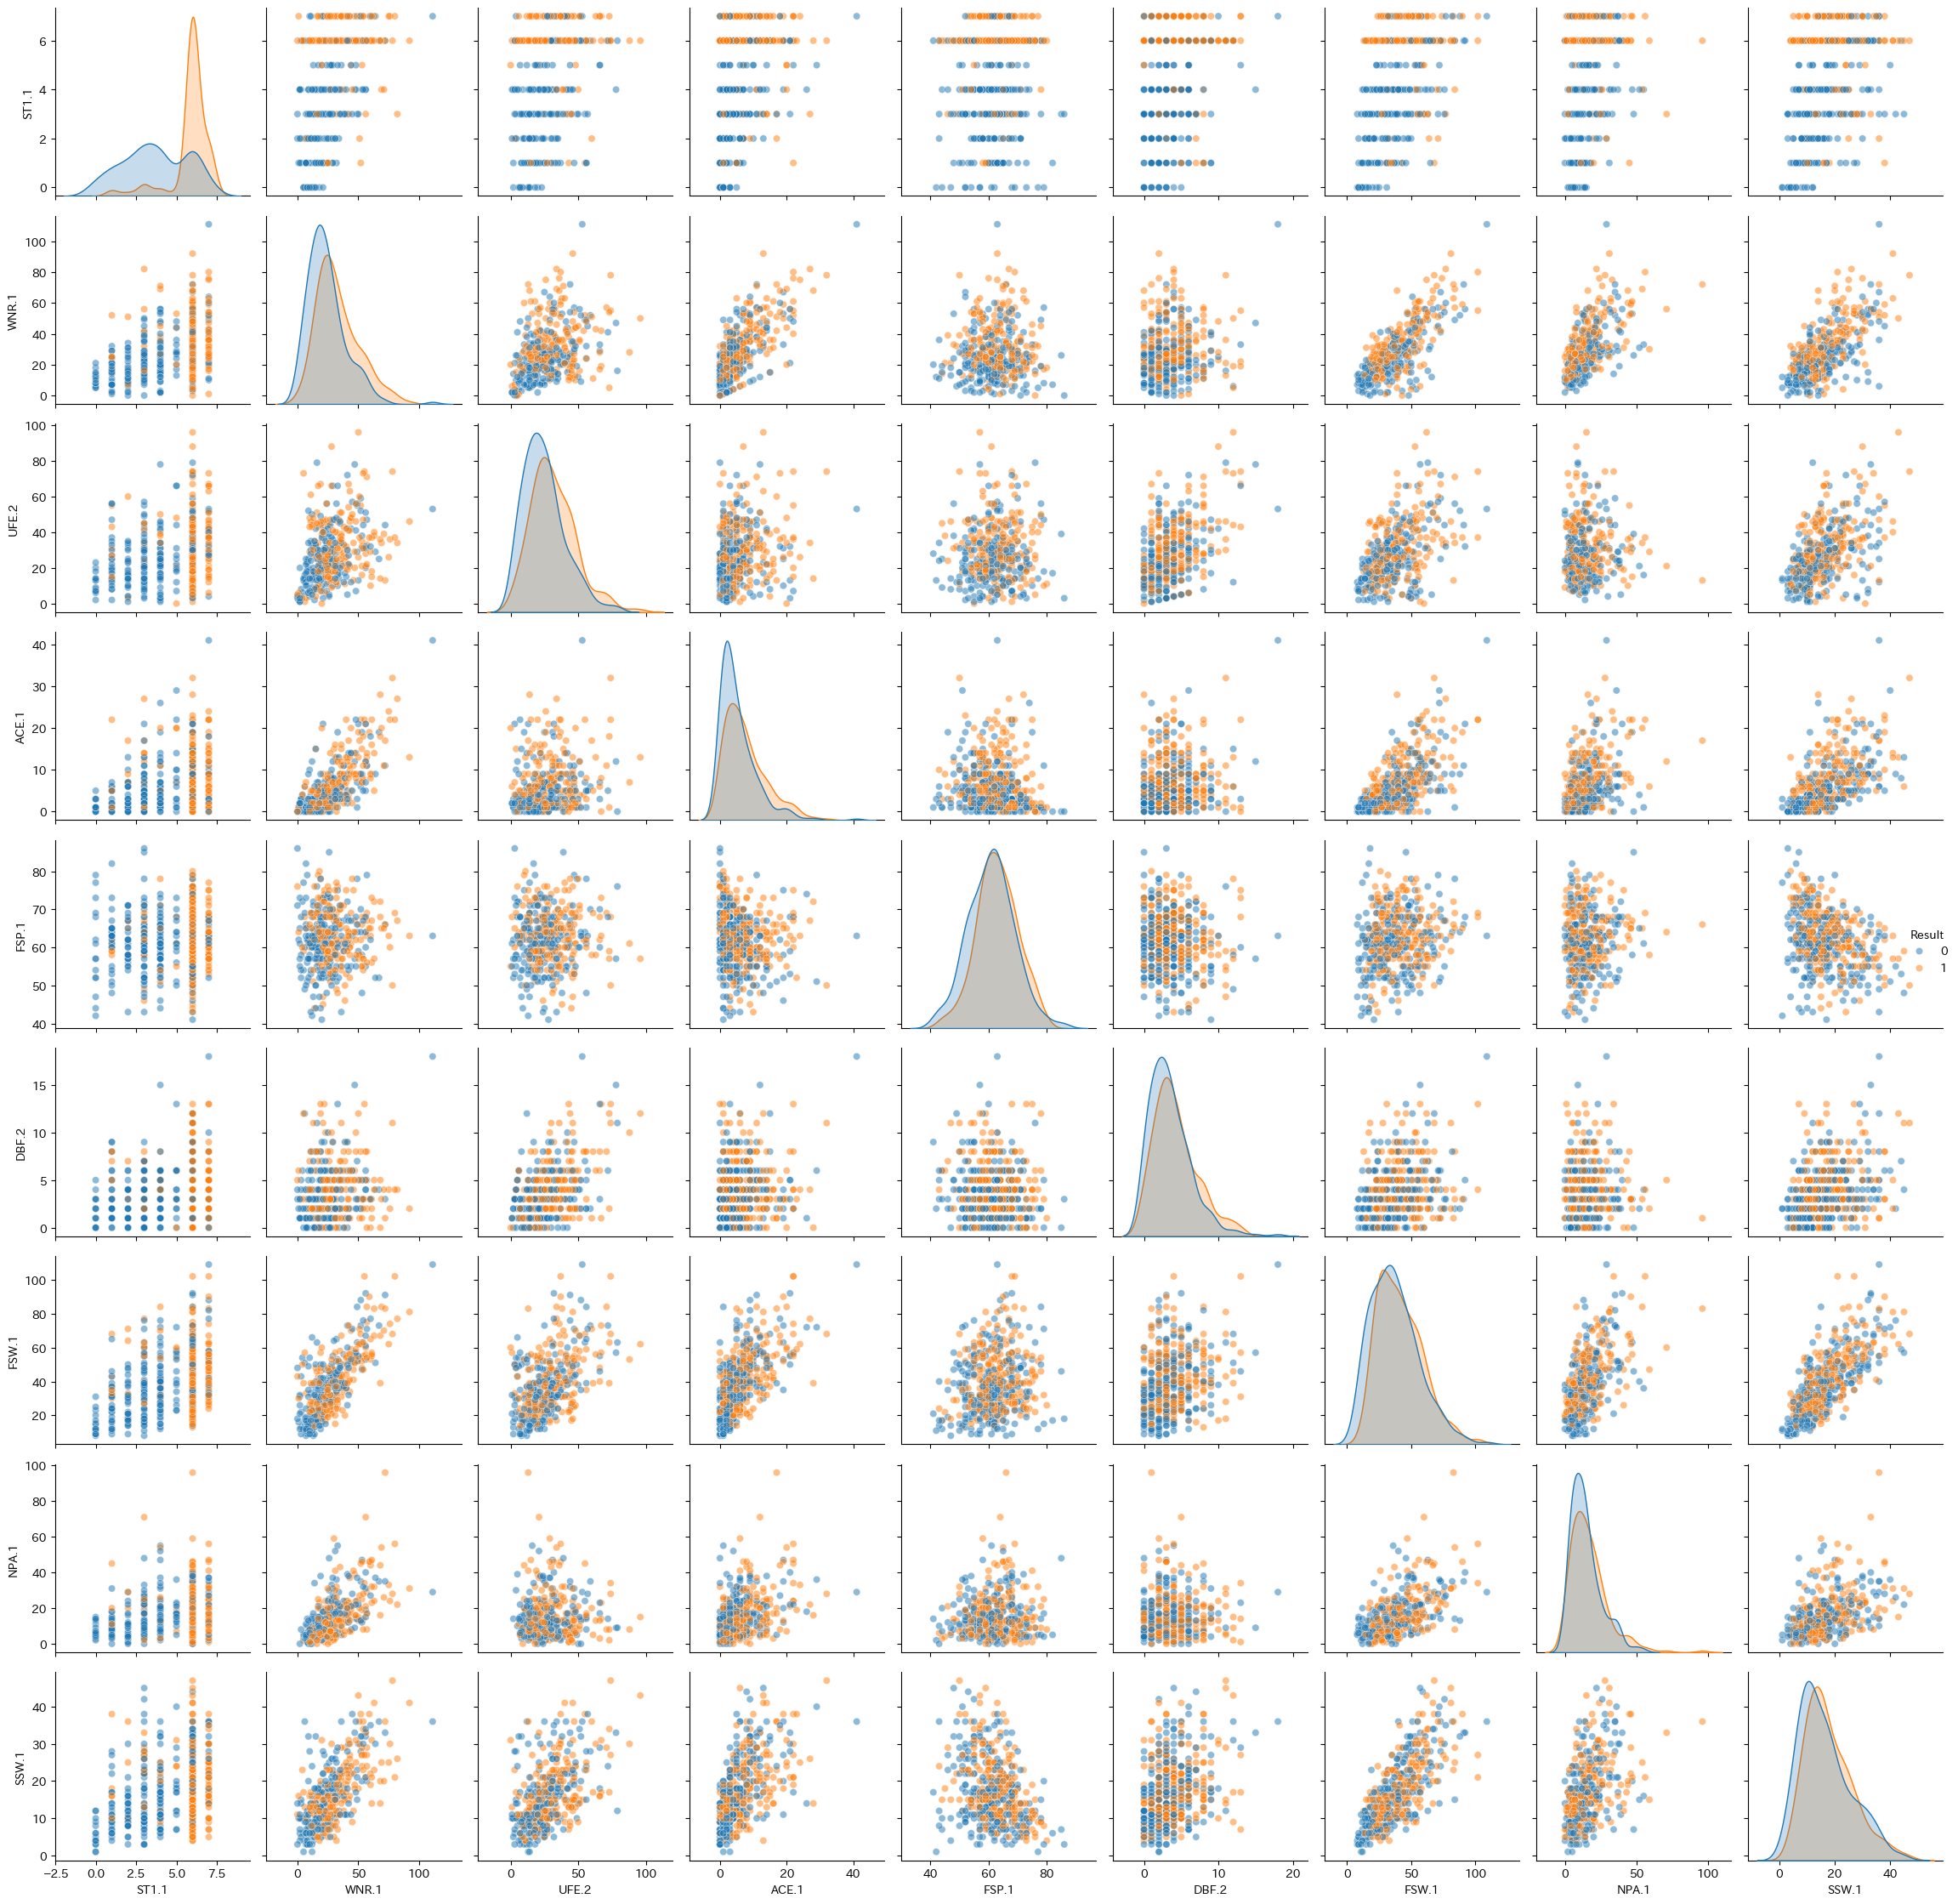

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# 相関が高い10変数 + 目的変数（Result）をリストで定義
target_cols = [
    "ST1.1", "WNR.1", "UFE.2", "ACE.1", "FSP.1",
    "DBF.2", "FSW.1", "NPA.1", "SSW.1", "Tournament", "Result"
]

# 対象列だけ抽出（.copy() で警告回避）
plot_data = df_train[target_cols].copy()

# Tournamentがカテゴリ変数なら、ここで型変換
if plot_data["Tournament"].dtype != "object":
    plot_data["Tournament"] = plot_data["Tournament"].astype(str)

# pairplotの描画（hueでResultを色分け）
sns.pairplot(plot_data, hue="Result", diag_kind="kde", plot_kws={'alpha': 0.5})

plt.tight_layout()
plt.show()


In [41]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          471 non-null    int64  
 1   Tournament  471 non-null    int64  
 2   Sex         471 non-null    int64  
 3   Round       471 non-null    int64  
 4   Result      471 non-null    int64  
 5   FSP.1       471 non-null    int64  
 6   FSW.1       471 non-null    int64  
 7   SSP.1       471 non-null    int64  
 8   SSW.1       471 non-null    int64  
 9   ACE.1       462 non-null    float64
 10  DBF.1       468 non-null    float64
 11  WNR.1       408 non-null    float64
 12  UFE.1       408 non-null    float64
 13  NPA.1       426 non-null    float64
 14  NPW.1       427 non-null    float64
 15  ST1.1       471 non-null    int64  
 16  FSP.2       471 non-null    int64  
 17  FSW.2       471 non-null    int64  
 18  SSP.2       471 non-null    int64  
 19  SSW.2       471 non-null    i

## PCA分析

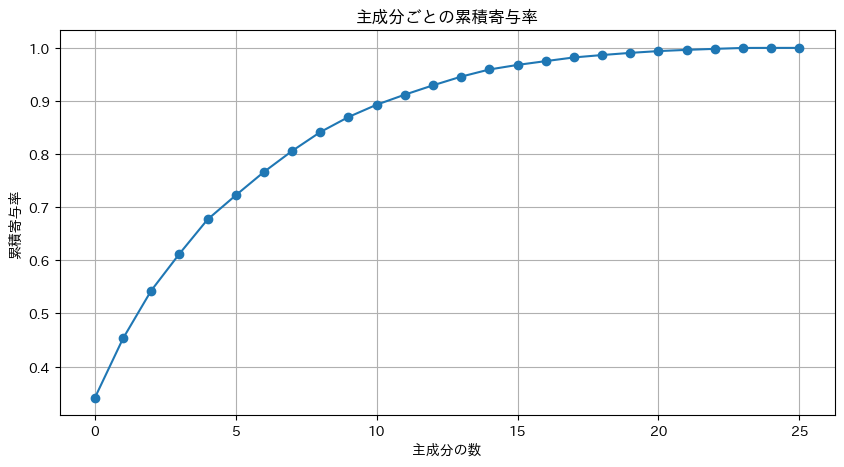

第1主成分への寄与:
 FSW.2         0.313236
FSW.1         0.312696
SSW.1         0.284764
SSW.2         0.283413
WNR.1         0.281009
WNR.2         0.277067
NPW.2         0.257433
NPW.1         0.249569
ACE.2         0.229745
ACE.1         0.226383
NPA.2         0.210912
NPA.1         0.208497
UFE.1         0.200988
UFE.2         0.187207
DBF.2         0.101371
DBF.1         0.091972
ST1.1         0.085269
ST1.2         0.070189
FSP.1         0.019585
SSP.2         0.001526
FSP.2        -0.001526
Round        -0.003511
id           -0.015018
Tournament   -0.017712
SSP.1        -0.021176
Sex          -0.242184
Name: PC1, dtype: float64


In [42]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 使用する特徴量（Tournamentがカテゴリであれば数値に変換）
features = [
    "id", "Tournament", "Sex", "Round", 
    "FSP.1", "FSW.1", "SSP.1", "SSW.1", "ACE.1", "DBF.1", "WNR.1", "UFE.1",
    "NPA.1", "NPW.1", "ST1.1",
    "FSP.2", "FSW.2", "SSP.2", "SSW.2", "ACE.2", "DBF.2", "WNR.2", "UFE.2",
    "NPA.2", "NPW.2", "ST1.2"
]

# データをコピーして加工
pca_data = df_train[features].dropna().copy()


# Tournament をエンコード（必要な場合）
if pca_data["Tournament"].dtype == "object":
    le = LabelEncoder()
    pca_data["Tournament"] = le.fit_transform(pca_data["Tournament"])

# 標準化（PCA前に重要）
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pca_data)

# PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# 寄与率（各主成分の重要度）
explained_variance = pca.explained_variance_ratio_

# スクリープロット（何次元使うかを判断）
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('主成分の数')
plt.ylabel('累積寄与率')
plt.title('主成分ごとの累積寄与率')
plt.grid(True)
plt.show()

# 各変数の主成分への寄与（第1主成分を例に）
loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(len(features))], index=features)
print("第1主成分への寄与:\n", loadings["PC1"].sort_values(ascending=False))


## shap

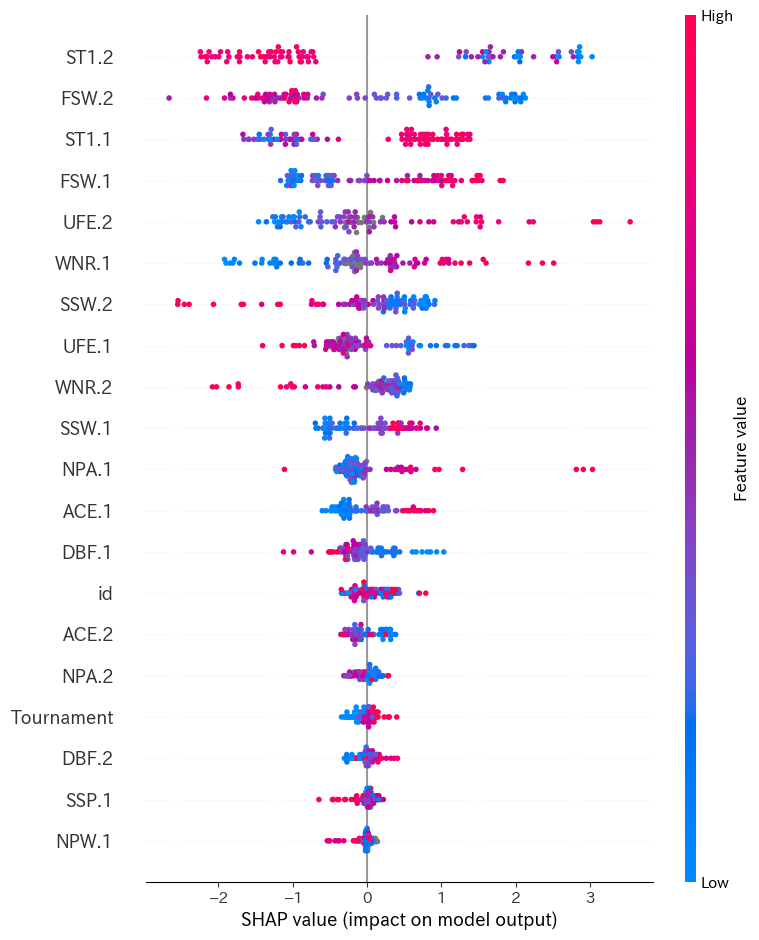

In [43]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = df_train[features]  # あなたが整理した変数群
y = df_train["Result"]

# データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# モデル学習
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# SHAPのTreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 可視化（Summary plot）
shap.summary_plot(shap_values, X_test)  # 1はpositiveクラス（勝利）のSHAP


## U-MAP

umap_scaledのサイズ: (384, 10)
embeddedのサイズ: (384, 2)


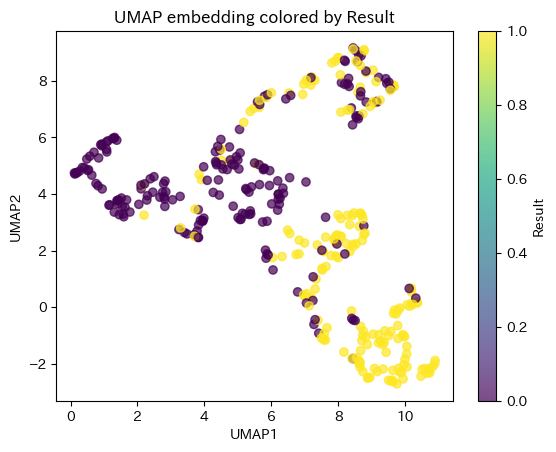

In [44]:
import umap.umap_ as umap
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 特徴量の選択と欠損値除去
features = ['FSW.1', 'WNR.1', 'NPW.1', 'UFE.1', 'ST1.1','FSW.2', 'WNR.2', 'NPW.2', 'UFE.2', 'ST1.2'
            ]
umap_df = df_train[features].dropna()

# スケーリング
scaler = RobustScaler()
umap_scaled = scaler.fit_transform(umap_df)
print("umap_scaledのサイズ:", umap_scaled.shape)



reducer = umap.UMAP(n_components=2, n_neighbors=5, random_state=42)
embedded = reducer.fit_transform(umap_scaled)

print("embeddedのサイズ:", embedded.shape)


# 欠損を除去したデータに対応するResultの値を取得
labels = df_train.loc[umap_df.index, 'Result'].values

# 可視化
plt.scatter(embedded[:, 0], embedded[:, 1], c=labels, alpha=0.7, cmap='viridis')
plt.colorbar(label='Result')
plt.title('UMAP embedding colored by Result')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()




## K-means

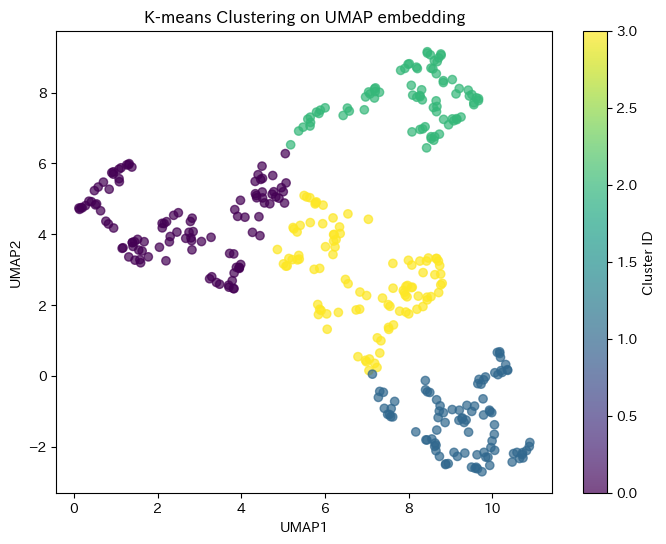

In [45]:
# UMAPの埋め込み空間でK-meansクラスタリング
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(embedded)

# クラスタリング結果の可視化
plt.figure(figsize=(8,6))
plt.scatter(embedded[:, 0], embedded[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title("K-means Clustering on UMAP embedding")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()



## エルボー法
急に緩やかになるところが適正なクラスタ数

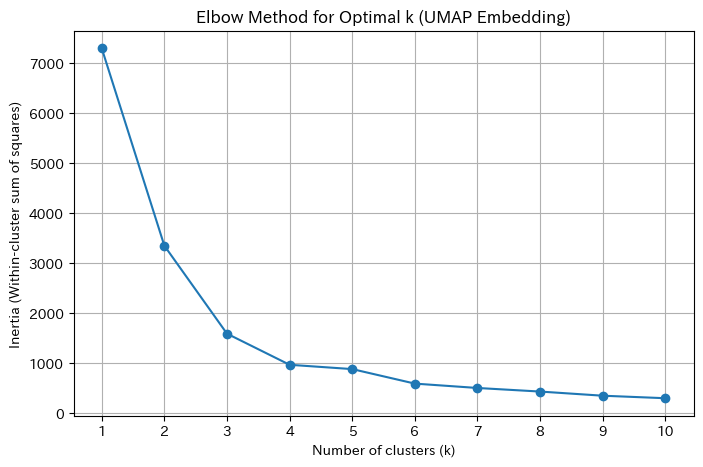

In [46]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1〜10クラスタまで試す
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embedded)  # embedded は UMAPの出力（2次元データ）
    inertias.append(kmeans.inertia_)

# 可視化
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method for Optimal k (UMAP Embedding)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster sum of squares)")
plt.xticks(K_range)
plt.grid(True)
plt.show()


In [47]:
# 元のdf_trainにクラスタ番号を追加（index合わせ注意）
df_train.loc[umap_df.index, 'cluster'] = cluster_labels

In [48]:
df_train.groupby("cluster").mean()

,id,Tournament,Sex,Round,Result,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,NPA.1,NPW.1,ST1.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,NPA.2,NPW.2,ST1.2
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,466.345455,1.363636,0.745455,2.054545,0.090909,60.200000,24.845455,39.800000,11.290909,2.598131,3.333333,17.400000,28.445455,9.681818,10.800000,2.327273,62.218182,29.918182,37.781818,13.354545,4.252336,3.064815,25.409091,22.581818,9.636364,10.190909,6.054545
1.0,493.308511,1.478723,0.851064,1.989362,0.904255,63.446809,28.095745,36.659574,11.946809,3.933333,2.574468,22.265957,20.691489,8.925532,8.638298,6.063830,61.925532,23.319149,38.074468,9.840426,1.822222,3.648936,15.989362,26.925532,9.180851,8.957447,2.627660
2.0,434.308642,1.061728,0.098765,1.962963,0.555556,63.197531,64.802469,36.802469,26.925926,11.312500,4.740741,50.925926,46.012346,24.765432,29.308642,5.530864,62.753086,63.543210,37.246914,26.728395,9.875000,5.074074,47.703704,46.506173,25.839506,30.296296,5.382716
3.0,469.505051,1.787879,0.333333,2.202020,0.505051,62.868687,39.313131,37.131313,16.494949,7.336735,3.020408,32.666667,25.474747,20.020408,19.919192,5.343434,63.484848,40.151515,36.515152,16.272727,6.408163,3.377551,30.858586,25.585859,20.489796,19.262626,4.757576


## クラスター
- 0 : (女)勝率低い、積極的にポイントを取っていっていない、1st,ace,wnrの数値も低い
- 1 : (女)勝率高い、積極的なプレースタイルで、サービスエース、ミスの数も少ない
- 2 : (男)勝率半々、3グループより少し勝率が高い、特にwnrエースがとても多い
- 3 : (男)勝率半々、若干勝率は低い、ミスの数はほぼ一緒なので、相手が積極的なプレーで押し負けた感じ

In [49]:
## 割合
pd.crosstab(df_train['cluster'], df_train['Sex'], normalize='index')


Sex,0,1
cluster,,
0.0,0.254545,0.745455
1.0,0.148936,0.851064
2.0,0.901235,0.098765
3.0,0.666667,0.333333


In [50]:
## 合計
pd.crosstab(df_train['Tournament'], df_train['Result'], margins = "all")

Result,0,1,All
Tournament,,,
0,72,60,132
1,65,55,120
2,53,44,97
3,57,65,122
All,247,224,471


In [51]:
## 割合
pd.crosstab(df_train['Sex'], df_train['FSW.1'], margins="all")


FSW.1,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,81,82,83,84,88,90,91,92,102,109,All
Sex,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,1,0,2,0,1,0,1,2,2,1,1,1,1,1,1,2,0,2,4,5,6,1,3,5,5,9,5,13,11,9,3,5,7,5,4,9,5,4,6,8,5,5,4,8,7,6,4,4,3,3,4,6,2,3,1,4,4,2,3,2,4,1,1,2,2,2,1,2,3,1,1,1,1,2,1,256
1,2,5,3,5,3,4,6,5,9,8,2,5,8,7,12,14,5,13,9,8,5,8,10,8,5,5,5,2,3,2,4,2,1,1,3,2,0,2,1,4,0,2,0,2,1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,215
All,2,5,3,6,3,6,6,6,9,9,4,7,9,8,13,15,6,14,11,8,7,12,15,14,6,8,10,7,12,7,17,13,10,4,8,9,5,6,10,9,4,8,8,7,6,7,8,7,7,4,4,3,3,4,6,2,3,1,4,4,2,3,2,4,1,1,2,2,2,1,2,3,1,1,1,1,2,1,471


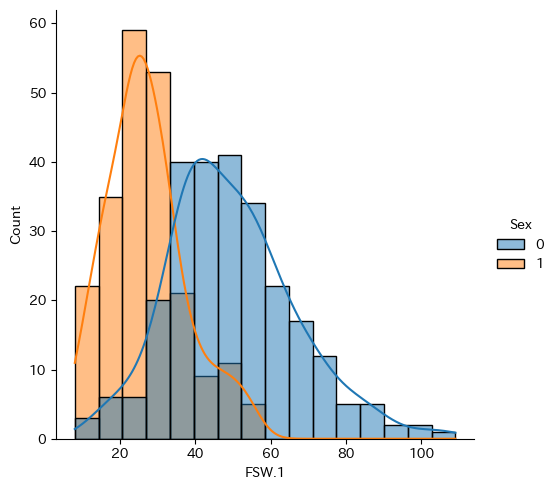

In [52]:
# ミスの数
sns.displot(x = "FSW.1", data = df_train, hue = "Sex", kde = True)
plt.show()

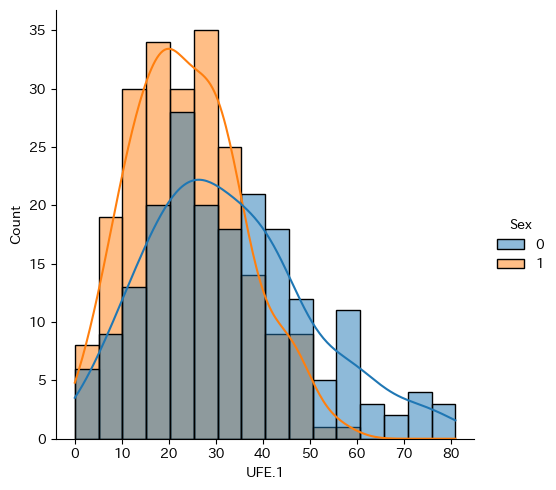

In [53]:
# ミスの数
sns.displot(x = "UFE.1", data = df_train, hue = "Sex", kde = True)
plt.show()

In [54]:
df_train.head()

,id,Tournament,Sex,Round,Result,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,NPA.1,NPW.1,ST1.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,NPA.2,NPW.2,ST1.2,cluster
0,0,1,0,1,1,69,84,31,29,11.0,4.0,57.0,42.0,8.0,13.0,6,54,58,46,36,7.0,8.0,60.0,71.0,24.0,33.0,4,2.0
1,3,0,1,2,0,63,34,37,10,1.0,4.0,23.0,47.0,9.0,10.0,6,58,29,42,16,0.0,3.0,10.0,19.0,1.0,2.0,4,1.0
2,4,3,1,1,0,53,18,47,13,4.0,2.0,11.0,15.0,7.0,4.0,3,63,25,37,10,8.0,2.0,23.0,18.0,8.0,5.0,6,0.0
3,7,2,1,1,1,51,13,49,12,1.0,0.0,13.0,8.0,8.0,6.0,6,43,8,57,5,0.0,8.0,3.0,18.0,6.0,3.0,0,1.0
4,9,0,1,1,0,72,54,28,10,4.0,7.0,4.0,7.0,NaN,NaN,6,49,36,51,25,5.0,6.0,5.0,6.0,NaN,NaN,3,NaN


## ベンチマークモデル作成
- ベースラインの善し悪しを決めるために、検証用と、ベースライン用の精度のギャップが少ないことを確認
- 混同行列を作成して、語分類の傾向も似ているかどうかを確認する。
- 検証用、ベースライン用の分布を確認して、似ているかどうか

In [55]:
from sklearn.model_selection import train_test_split

# 特徴量
features = ['FSW.1', 'WNR.1', 'NPW.1', 'UFE.1', 'ST1.1','FSW.2', 'NPW.2', 'UFE.2','SSW.2','WNR.2','FSP.1']

"""""
【精度を上げた変数】
'FSW.1', 'WNR.1', 'NPW.1', 'UFE.1', 'ST1.1','FSW.2', 'NPW.2', 'UFE.2','WNR.2','SSW.2'
【精度を下げた変数】
'ST1.2','Tournament','sex','Round','FSP.1','SSP.1','ACE.1','DBF.1','DBF.2','ACE.2','SSP.2','SSP.1'

"""


            

X_train, y_train = df_train[features].copy(), df_train[["Result"]].copy()
#X_test, y_test = df_test[features].copy(), df_test["Result"].copy()

# まずは全体を train+valid（80%）と benchmark（20%）に分割
X_tr, X_va2, y_tr, y_va2 = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train, #y_train のラベル比率（0と1の割合）を、分割後も保つようにする
    shuffle=True
)
# 結果確認
print(X_tr.shape,y_tr.shape)
print(X_va2.shape,y_va2.shape)


# 次に train+valid を train（64%）と valid（16%）に分割（もとの全体の80%×0.8 = 64%）
X_tr1, X_va1, y_tr1, y_va1 = train_test_split(
    X_tr, y_tr,
    test_size=0.2,
    random_state=42,
    stratify=y_tr,
    shuffle=True
)

# 結果確認
print(X_tr1.shape,y_tr1.shape)
print(X_va1.shape,y_va1.shape)


(376, 11) (376, 1)
(95, 11) (95, 1)
(300, 11) (300, 1)
(76, 11) (76, 1)


## クロスバリデーション

In [56]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import numpy as np
import pandas as pd

def evaluate_model_cv(X_tr, y_tr, X_base, y_base, params=None, n_splits=5, random_state=42):
    if params is None:
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': random_state
        }

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    val_accuracies = []
    baseline_accuracies = []

    best_model = None
    best_val_accuracy = 0

    print("=== Stratified K-Fold Cross Validation ===")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tr, y_tr)):
        print(f"\nFold {fold+1}/{n_splits}")

        X_train_fold = X_tr.iloc[train_idx]
        y_train_fold = y_tr.iloc[train_idx]
        X_val_fold = X_tr.iloc[val_idx]
        y_val_fold = y_tr.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(10)
            ]
        )

        # 検証データで評価
        y_val_pred = model.predict(X_val_fold)
        acc_val = accuracy_score(y_val_fold, y_val_pred)
        print(f"[検証データ] Accuracy: {acc_val:.4f}")
        print(confusion_matrix(y_val_fold, y_val_pred))
        print(confusion_matrix(y_val_fold, y_val_pred, normalize="all"))
        val_accuracies.append(acc_val)

        # ベースライン検証データで評価
        y_baseline_pred = model.predict(X_base)
        acc_base = accuracy_score(y_base, y_baseline_pred)
        print(f"[ベースライン検証データ] Accuracy: {acc_base:.4f}")
        print(confusion_matrix(y_base, y_baseline_pred))
        print(confusion_matrix(y_base, y_baseline_pred, normalize="all"))
        baseline_accuracies.append(acc_base)

        # 最良モデルの保存
        if acc_val > best_val_accuracy:
            best_val_accuracy = acc_val
            best_model = model

    print("\n=== クロスバリデーション平均結果 ===")
    print(f"検証データの平均 Accuracy: {np.mean(val_accuracies):.4f}")
    print(f"ベースライン検証データの平均 Accuracy: {np.mean(baseline_accuracies):.4f}")

    return val_accuracies, baseline_accuracies, best_model, params  # ←paramsも返す



In [57]:
# 例: 評価関数の実行とモデル取得
val_accs, base_accs, best_model, best_params = evaluate_model_cv(X_tr1, y_tr1, X_va2, y_va2)

=== Stratified K-Fold Cross Validation ===

Fold 1/5
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.468551
[20]	valid_0's binary_logloss: 0.424257
[30]	valid_0's binary_logloss: 0.397968
[40]	valid_0's binary_logloss: 0.39648
[50]	valid_0's binary_logloss: 0.387057
[60]	valid_0's binary_logloss: 0.384329
[70]	valid_0's binary_logloss: 0.387855
[80]	valid_0's binary_logloss: 0.383997
[90]	valid_0's binary_logloss: 0.39793
[100]	valid_0's binary_logloss: 0.406419
Did not meet early stopping. Best iteration is:
[76]	valid_0's binary_logloss: 0.378537
[検証データ] Accuracy: 0.8833
[[29  2]
 [ 5 24]]
[[0.48333333 0.03333333]
 [0.08333333 0.4       ]]
[ベースライン検証データ] Accuracy: 0.8421
[[42  8]
 [ 7 38]]
[[0.44210526 0.08421053]
 [0.07368421 0.4       ]]

Fold 2/5
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.441138
[20]	valid_0's binary_logloss: 0.390866
[30]	valid_0's binary_logloss: 0.362594
[40]	valid_0

## 提出用ファイルの作成

In [58]:

# ベストパラメータで再学習（全データ使用）
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_tr1, y_tr1)

# テストデータの予測
X_test = df_test[features].copy()
y_test_pred = final_model.predict(X_test)

In [ ]:

# 提出用CSVの作成
submission = pd.DataFrame({
    'id': df_test['id'],  # 適宜修正
    'Result': y_test_pred
})
submission.to_csv("submission.csv", index=False, header=False)


In [60]:
submission.head()


,id,Result
0,1,1
1,2,1
2,5,1
3,6,0
4,8,1


## 前処理

In [63]:
df_train.isnull().sum()

id             0
Tournament     0
Sex            0
Round          0
Result         0
FSP.1          0
FSW.1          0
SSP.1          0
SSW.1          0
ACE.1          9
DBF.1          3
WNR.1         63
UFE.1         63
NPA.1         45
NPW.1         44
ST1.1          0
FSP.2          0
FSW.2          0
SSP.2          0
SSW.2          0
ACE.2          9
DBF.2          3
WNR.2         63
UFE.2         63
NPA.2         45
NPW.2         44
ST1.2          0
cluster       87
dtype: int64

In [71]:
df_train['DBF.1'].describe()

count    468.000000
mean       3.685897
std        2.656182
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max       18.000000
Name: DBF.1, dtype: float64

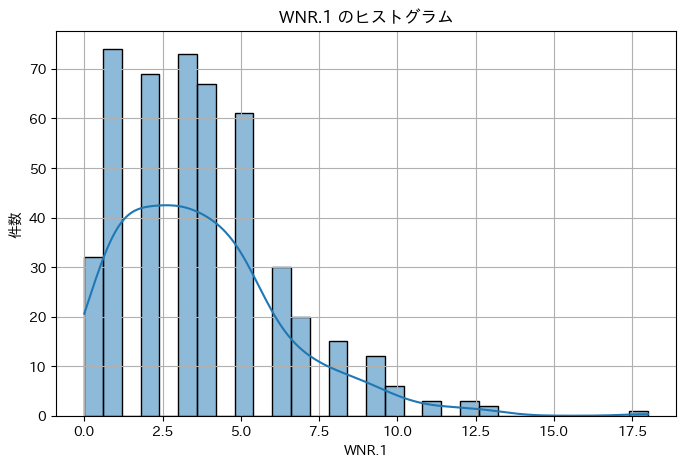

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df_train['DBF.1'], bins=30, kde=True)
plt.title('WNR.1 のヒストグラム')
plt.xlabel('WNR.1')
plt.ylabel('件数')
plt.grid(True)
plt.show()


In [74]:
df_train.loc[df_train['DBF.1'].isnull()]

,id,Tournament,Sex,Round,Result,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,NPA.1,NPW.1,ST1.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,NPA.2,NPW.2,ST1.2,cluster
98,189,1,0,2,0,61,19,39,16,2.0,NaN,12.0,14.0,3.0,14.0,2,62,30,38,18,3.0,NaN,54.0,33.0,19.0,30.0,6,3.0
240,503,0,0,1,0,64,26,36,12,3.0,NaN,20.0,39.0,5.0,14.0,5,67,42,33,14,12.0,NaN,32.0,20.0,8.0,11.0,7,0.0
428,844,1,1,2,0,82,17,18,6,0.0,NaN,7.0,11.0,5.0,10.0,1,75,26,25,5,1.0,NaN,29.0,17.0,7.0,11.0,6,0.0


In [75]:
df_train.loc[df_train['WNR.1'].isnull()]

,id,Tournament,Sex,Round,Result,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,NPA.1,NPW.1,ST1.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,NPA.2,NPW.2,ST1.2,cluster
8,19,2,0,1,1,68,49,32,19,5.0,1.0,NaN,NaN,27.0,39.0,6,56,29,44,23,2.0,4.0,NaN,NaN,10.0,21.0,3,NaN
24,53,2,0,1,0,74,72,26,14,26.0,5.0,NaN,NaN,18.0,31.0,4,73,73,27,20,6.0,1.0,NaN,NaN,15.0,18.0,6,NaN
37,82,2,0,1,0,53,59,47,44,8.0,8.0,NaN,NaN,NaN,NaN,6,59,65,41,38,2.0,7.0,NaN,NaN,NaN,NaN,7,NaN
50,106,2,0,1,1,57,36,43,15,8.0,4.0,NaN,NaN,19.0,24.0,6,65,27,35,9,1.0,0.0,NaN,NaN,9.0,18.0,3,NaN
52,108,2,0,1,1,68,30,32,12,3.0,2.0,NaN,NaN,22.0,30.0,6,59,30,41,10,2.0,3.0,NaN,NaN,10.0,21.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,879,2,0,1,1,57,41,43,35,5.0,3.0,NaN,NaN,17.0,26.0,7,63,40,37,16,6.0,5.0,NaN,NaN,29.0,50.0,5,NaN
454,898,2,0,1,0,64,65,36,25,9.0,9.0,NaN,NaN,NaN,NaN,6,63,66,37,23,6.0,3.0,NaN,NaN,NaN,NaN,1,NaN
459,909,2,0,1,1,61,44,39,19,3.0,2.0,NaN,NaN,NaN,NaN,6,56,37,44,15,18.0,8.0,NaN,NaN,NaN,NaN,3,NaN
463,919,2,0,1,1,60,41,40,21,12.0,2.0,NaN,NaN,20.0,21.0,6,49,29,51,18,9.0,9.0,NaN,NaN,5.0,13.0,3,NaN


## 欠損値補完

In [15]:
# 対象カラムリスト
cols_to_impute = ['WNR.1', 'UFE.1', 'WNR.2', 'UFE.2', 'NPW.1', 'NPW.2', 'NPA.1', 'NPA.2']
cols_to_zero = ['ACE.1','DBF.1','ACE.2','DBF.2']
# 各列に対して中央値で補完
for col in cols_to_impute:
    median_val = df_train[col].median()
    df_train[col] = df_train[col].fillna(median_val)
for cols in cols_to_zero:
    df_train[cols] = df_train[cols].fillna(0)

In [16]:
df_train.isnull().sum()

id            0
Tournament    0
Sex           0
Round         0
Result        0
FSP.1         0
FSW.1         0
SSP.1         0
SSW.1         0
ACE.1         0
DBF.1         0
WNR.1         0
UFE.1         0
NPA.1         0
NPW.1         0
ST1.1         0
FSP.2         0
FSW.2         0
SSP.2         0
SSW.2         0
ACE.2         0
DBF.2         0
WNR.2         0
UFE.2         0
NPA.2         0
NPW.2         0
ST1.2         0
dtype: int64

## 特徴量生成
- 積極的な選手と守備的な選手
- サーブの得点率、ラリーエース
- アンフォースエラーが多いか少ないかなどなど

In [104]:
df_train['attack_score.1'] = df_train['ACE.1']+df_train['WNR.1']-df_train['DBF.1']-df_train['UFE.1']
df_train['ace_ratio.1'] = df_train['ACE.1']/(df_train['ACE.1']+df_train['DBF.1'])
df_train['winner_ace_ratio.1'] = df_train['WNR.1'] / (df_train['WNR.1'] + df_train['UFE.1'] + 1)
df_test['winner_ace_ratio.1'] = df_test['WNR.1'] / (df_test['WNR.1'] + df_test['UFE.1'] + 1)
df_train['net_play_ratio_1'] = df_train['NPW.1'] / (df_train['NPA.1'] + 1)

df_train["aggressiveness_1"] = (
    df_train["ACE.1"] * 1.0 +
    df_train["WNR.1"] * 0.8 -
    df_train["UFE.1"] * 0.7 -
    df_train["DBF.1"] * 0.5
)
df_test["aggressiveness_1"] = (
    df_test["ACE.1"] * 1.0 +
    df_test["WNR.1"] * 0.8 -
    df_test["UFE.1"] * 0.7 -
    df_test["DBF.1"] * 0.5
)
df_train["aggressiveness_2"] = (
    df_train["ACE.2"] * 1.0 +
    df_train["WNR.2"] * 0.8 -
    df_train["UFE.2"] * 0.7 -
    df_train["DBF.2"] * 0.5
)
df_train["attack_success_ratio_1"] = df_train["WNR.1"] / (df_train["WNR.1"] + df_train["UFE.1"] + 1)


In [105]:
df_train['long_rally_success_1'] = df_train['SSW.1'] / df_train['SSP.1']
df_test['long_rally_success_1'] = df_test['SSW.1'] / df_test['SSP.1']
df_train['long_rally_success_2'] = df_train['SSW.2'] / df_train['SSP.2']
df_train['low_risk_score_1'] = (df_train['FSW.1'] + df_train['SSW.1']) / (df_train['FSP.1'] + df_train['SSP.1'])

In [106]:
df_train[features].corr()

,FSW.1,WNR.1,NPW.1,UFE.1,ST1.1,FSW.2,NPW.2,UFE.2,SSW.2,WNR.2,long_rally_success_1,aggressiveness_1
FSW.1,1.000000,0.699953,0.621662,0.458131,0.338280,0.877111,0.606269,0.451311,0.755984,0.617314,0.880587,0.525608
WNR.1,0.699953,1.000000,0.574895,0.566555,0.343092,0.648921,0.396095,0.373506,0.456222,0.551331,0.647226,0.727233
NPW.1,0.621662,0.574895,1.000000,0.368106,0.146249,0.606855,0.615684,0.167104,0.515268,0.424365,0.599022,0.393946
UFE.1,0.458131,0.566555,0.368106,1.000000,0.054127,0.490778,0.269258,0.571885,0.370593,0.473545,0.421961,-0.103109
ST1.1,0.338280,0.343092,0.146249,0.054127,1.000000,0.146673,0.144122,0.253432,0.101573,0.016214,0.329508,0.358627
FSW.2,0.877111,0.648921,0.606855,0.490778,0.146673,1.000000,0.630397,0.393933,0.729987,0.674520,0.852498,0.443987
NPW.2,0.606269,0.396095,0.615684,0.269258,0.144122,0.630397,1.000000,0.387031,0.527927,0.539514,0.618863,0.272853
UFE.2,0.451311,0.373506,0.167104,0.571885,0.253432,0.393933,0.387031,1.000000,0.342691,0.604113,0.487462,-0.003222
SSW.2,0.755984,0.456222,0.515268,0.370593,0.101573,0.729987,0.527927,0.342691,1.000000,0.538111,0.732928,0.328515
WNR.2,0.617314,0.551331,0.424365,0.473545,0.016214,0.674520,0.539514,0.604113,0.538111,1.000000,0.593110,0.280674


## Oputuna

In [200]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import numpy as np
import pandas as pd
import optuna


# 特徴量
features = ['FSW.1', 'WNR.1', 'NPW.1', 'UFE.1', 'ST1.1','FSW.2', 'NPW.2', 'UFE.2','SSW.2','WNR.2','long_rally_success_1',"aggressiveness_1"]
"""""
【精度を上げた変数】
'FSW.1', 'WNR.1', 'NPW.1', 'UFE.1', 'ST1.1','FSW.2', 'NPW.2', 'UFE.2','WNR.2','SSW.2','long_rally_success_1',"aggressiveness_1"
【精度を下げた変数】
'ST1.2','Tournament','sex','Round','FSP.1','SSP.1','ACE.1','DBF.1','DBF.2','ACE.2','SSP.2','SSP.1','attack_score.1','ace_ratio.1','winner_ace_ratio.1'
'net_play_ratio_1','low_risk_score_1',"attack_success_ratio_1"

"""


            
# 学習データ準備
X_train, y_train = df_train[features].copy(), df_train["Result"].copy()

# train+valid(80%)とtest(20%)に分割
X_tr, X_va2, y_tr, y_va2 = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train, shuffle=True
)

# train(64%)とvalid(16%)に分割
X_tr1, X_va1, y_tr1, y_va1 = train_test_split(
    X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr, shuffle=True
)

# CV分割の準備
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_tr, y_tr))

# Optunaで最適なハイパーパラメータを探す
def optimize_params_with_optuna(X, y, folds, n_trials=30):
    def objective(trial):
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': 42,  # ←これが必要
            'feature_pre_filter': False,
            'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
            'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 4, 64),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

        scores = []
        for train_idx, val_idx in folds:
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

            dtrain = lgb.Dataset(X_train_fold, y_train_fold)
            dvalid = lgb.Dataset(X_val_fold, y_val_fold, reference=dtrain)

            model = lgb.train(
                params,
                dtrain,
                valid_sets=[dvalid],
                num_boost_round=1000,
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=False),
                    lgb.log_evaluation(period=0)
                ]
            )

            y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
            y_pred_label = (y_pred > 0.5).astype(int)
            acc = accuracy_score(y_val_fold, y_pred_label)
            scores.append(acc)

        return 1 - np.mean(scores)

    study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=42)
)

    study.optimize(objective, n_trials=n_trials)
    return study.best_params, study

def evaluate_model_cv(X_tr, y_tr, params, folds, X_va2=None, y_va2=None):
    val_accuracies = []
    base_accuracies = []
    models = []

    for fold, (train_idx, val_idx) in enumerate(folds):
        print(f"Fold {fold + 1}/{len(folds)}")
        X_train_fold, X_val_fold = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
        y_train_fold, y_val_fold = y_tr.iloc[train_idx], y_tr.iloc[val_idx]

        train_dataset = lgb.Dataset(X_train_fold, y_train_fold)
        val_dataset = lgb.Dataset(X_val_fold, y_val_fold, reference=train_dataset)

        model = lgb.train(
            params,
            train_dataset,
            valid_sets=[val_dataset],
            num_boost_round=1000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=50),
                lgb.log_evaluation(period=10)
            ]
        )

        y_pred = model.predict(X_val_fold, num_iteration=model.best_iteration)
        y_pred_label = (y_pred > 0.5).astype(int)

        acc = accuracy_score(y_val_fold, y_pred_label)
        val_accuracies.append(acc)

        # ベースライン（最頻値）との比較
        y_base_pred = [y_tr.mode().values[0]] * len(y_val_fold)
        base_acc = accuracy_score(y_val_fold, y_base_pred)
        base_accuracies.append(base_acc)

        models.append(model)

    print("=== クロスバリデーション平均結果 ===")
    print(f"検証データの平均 Accuracy: {np.mean(val_accuracies):.4f}")
    print(f"ベースライン検証データの平均 Accuracy: {np.mean(base_accuracies):.4f}")

    # ここで別の検証データX_va2,y_va2があれば評価も表示
    if X_va2 is not None and y_va2 is not None:
        print("=== 別検証データ X_va2 の評価 ===")
        # 最後に学習したfoldモデルで予測
        y_va_pred = models[-1].predict(X_va2, num_iteration=models[-1].best_iteration)
        y_va_pred_label = (y_va_pred > 0.5).astype(int)
        va_acc = accuracy_score(y_va2, y_va_pred_label)
        print(f"X_va2のAccuracy: {va_acc:.4f}")

    return val_accuracies, base_accuracies, models[-1], models

#ハイパーパラメーター探索
best_params, study = optimize_params_with_optuna(X_tr, y_tr, folds, n_trials=30)


[I 2025-06-10 17:11:04,735] A new study created in memory with name: no-name-3a9e6667-a951-4416-bb55-0e4d3be0456a


[I 2025-06-10 17:11:05,420] Trial 0 finished with value: 0.1356140350877194 and parameters: {'lambda_l1': 2.348881295853308e-05, 'lambda_l2': 3.6010467344475403, 'num_leaves': 48, 'feature_fraction': 0.759195090518222, 'bagging_fraction': 0.4936111842654619, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.1356140350877194.
[I 2025-06-10 17:11:05,725] Trial 1 finished with value: 0.16224561403508775 and parameters: {'lambda_l1': 0.6245760287469893, 'lambda_l2': 0.002570603566117598, 'num_leaves': 47, 'feature_fraction': 0.41235069657748147, 'bagging_fraction': 0.9819459112971965, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.1356140350877194.
[I 2025-06-10 17:11:06,005] Trial 2 finished with value: 0.15957894736842104 and parameters: {'lambda_l1': 4.329370014459266e-07, 'lambda_l2': 4.4734294104626844e-07, 'num_leaves': 22, 'feature_fraction': 0.7148538589793427, 'bagging_fraction': 0.6591670111852694, 'bagging_freq': 3, 'min_child

In [201]:
# 最適パラメータで再評価・SHAP用に再学習
# 正しい呼び出し
val_accs, base_accs, best_model, all_models = evaluate_model_cv(X_tr, y_tr, best_params, folds=kf, X_va2=X_va2, y_va2=y_va2)

Fold 1/5
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 0.148745
[20]	valid_0's l2: 0.121984
[30]	valid_0's l2: 0.114742
[40]	valid_0's l2: 0.114078
[50]	valid_0's l2: 0.110732
[60]	valid_0's l2: 0.110951
[70]	valid_0's l2: 0.110479
[80]	valid_0's l2: 0.112129
[90]	valid_0's l2: 0.114591
[100]	valid_0's l2: 0.115838
Early stopping, best iteration is:
[56]	valid_0's l2: 0.109835
Fold 2/5
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 0.147217
[20]	valid_0's l2: 0.1183
[30]	valid_0's l2: 0.105452
[40]	valid_0's l2: 0.100527
[50]	valid_0's l2: 0.0965313
[60]	valid_0's l2: 0.0980974
[70]	valid_0's l2: 0.0957463
[80]	valid_0's l2: 0.0957579
[90]	valid_0's l2: 0.0979615
[100]	valid_0's l2: 0.0982267
[110]	valid_0's l2: 0.100752
[120]	valid_0's l2: 0.0985873
Early stopping, best iteration is:
[78]	valid_0's l2: 0.0941032
Fold 3/5
Training until validation scores don't improve for 50 rounds
[10]	valid_0's l2: 0.147942
[20]	valid

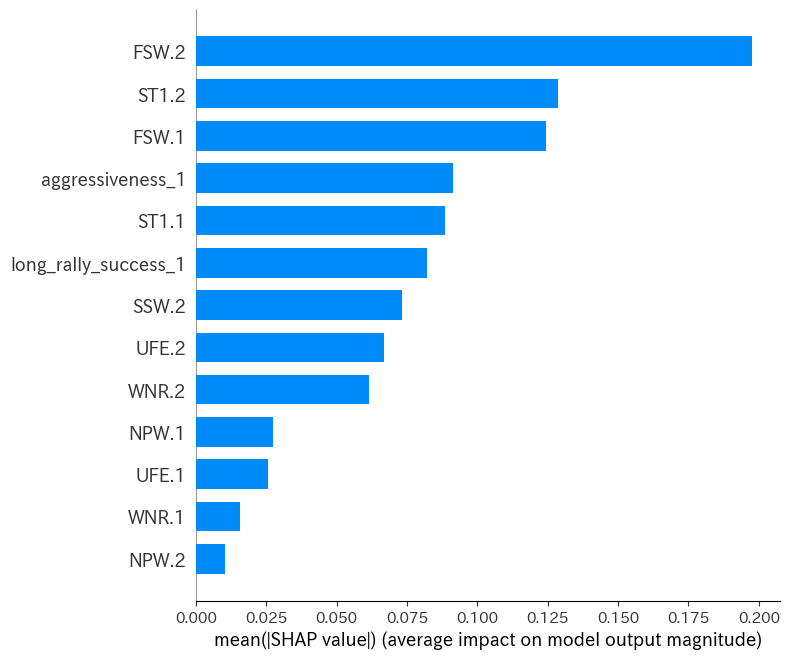

In [193]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt

# モデルの学習（例: すでに train_model などで学習済み）
# model = lgb.train(...)

# SHAPのexplainerを作成（TreeExplainerはLightGBMに最適）
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_va2)  # X_valid は検証用データ

# 要素数が多い場合はsummary plotを使うと良い
shap.summary_plot(shap_values, X_va2, plot_type="bar")


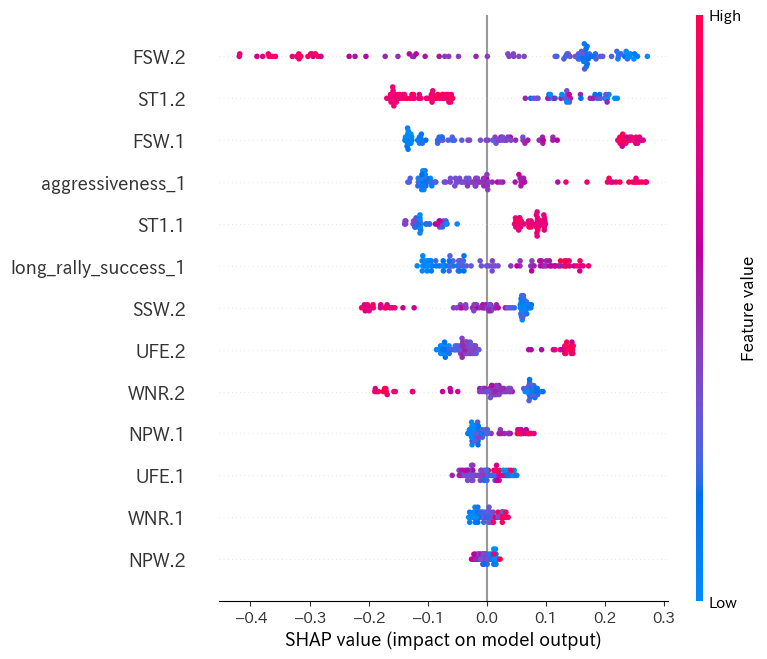

In [194]:
# SHAPのTreeExplainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_va2)

# 可視化（Summary plot）
shap.summary_plot(shap_values, X_va2)  # 1はpositiveクラス（勝利）のSHAP


<Axes: xlabel='ST1.1', ylabel='Count'>

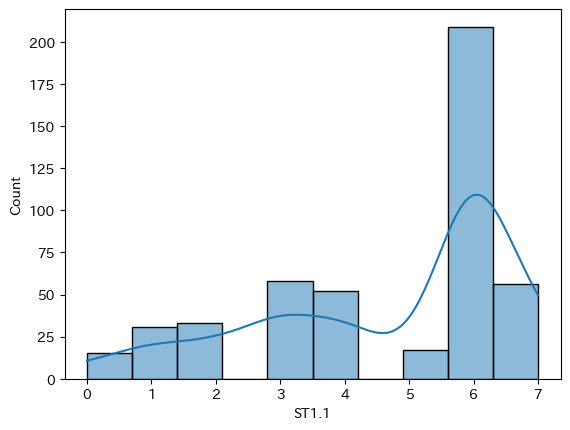

In [199]:
# その変数単体の分布を見てみる（怪しい外れ値がある？）
sns.histplot(df_train["ST1.1"], kde=True)

In [178]:

# 最終モデル学習は X_train, y_train（全体）を使う
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# テストデータに対する予測
X_test = df_test[features].copy()
y_test_pred = final_model.predict(X_test)

# 提出用ファイル作成
submission = pd.DataFrame({
    'id': df_test['id'],  # カラム名は適宜確認
    'Result': y_test_pred
})
submission.to_csv("submission.csv", index=False, header=False)



## データの結合

In [ ]:
#sort=Falrseで結合の並びを変えないようにする。　そしてreset_indexで結合後のデータで行を振り直す

all_data = pd.concat([train_df,test_df],sort=False).reset_index(drop=True)
all_data

,id,Tournament,Sex,Year,Player1,Player2,Round,Result,FNL.1,FNL.2,FSP.1,FSW.1,SSP.1,SSW.1,ACE.1,DBF.1,WNR.1,UFE.1,BPC.1,BPW.1,NPA.1,NPW.1,TPW.1,ST1.1,ST2.1,ST3.1,ST4.1,ST5.1,FSP.2,FSW.2,SSP.2,SSW.2,ACE.2,DBF.2,WNR.2,UFE.2,BPC.2,BPW.2,NPA.2,NPW.2,TPW.2,ST1.2,ST2.2,ST3.2,ST4.2,ST5.2
0,0,FrenchOpen,men,2013,Jarkko Nieminen,Paul-Henri Mathieu,1,1.0,3.0,2.0,69,84,31,29,11.0,4.0,57.0,42.0,6.0,7.0,8.0,13.0,172.0,6.0,4.0,7.0,4.0,6.0,54,58,46,36,7.0,8.0,60.0,71.0,5.0,15.0,24.0,33.0,163.0,4.0,6.0,6.0,6.0,2.0
1,3,AusOpen,women,2013,Varvara Lepchenko,Simona Halep,2,0.0,1.0,2.0,63,34,37,10,1.0,4.0,23.0,47.0,2.0,2.0,9.0,10.0,66.0,6.0,0.0,1.0,NaN,NaN,58,29,42,16,0.0,3.0,10.0,19.0,6.0,15.0,1.0,2.0,90.0,4.0,6.0,6.0,NaN,NaN
2,4,Wimbledon,women,2013,H.Watson,M.Keys,1,0.0,0.0,2.0,53,18,47,13,4.0,2.0,11.0,15.0,5.0,2.0,7.0,4.0,NaN,3.0,5.0,NaN,NaN,NaN,63,25,37,10,8.0,2.0,23.0,18.0,7.0,5.0,8.0,5.0,NaN,6.0,7.0,NaN,NaN,NaN
3,7,USOpen,women,2013,S Williams,F Schiavone,1,1.0,2.0,0.0,51,13,49,12,1.0,0.0,13.0,8.0,9.0,6.0,8.0,6.0,NaN,6.0,6.0,NaN,NaN,NaN,43,8,57,5,0.0,8.0,3.0,18.0,0.0,0.0,6.0,3.0,NaN,0.0,1.0,NaN,NaN,NaN
4,9,AusOpen,women,2013,Tadeja Majeric,Ajla Tomljanovic,1,0.0,1.0,2.0,72,54,28,10,4.0,7.0,4.0,7.0,3.0,6.0,NaN,NaN,99.0,6.0,6.0,4.0,NaN,NaN,49,36,51,25,5.0,6.0,5.0,6.0,3.0,6.0,NaN,NaN,97.0,3.0,7.0,6.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,938,FrenchOpen,women,2013,Vania King,Alexandra Cadantu,1,NaN,2.0,0.0,74,27,26,11,NaN,0.0,38.0,15.0,6.0,9.0,14.0,21.0,83.0,7.0,6.0,NaN,NaN,NaN,72,28,28,9,NaN,5.0,21.0,17.0,3.0,8.0,5.0,9.0,64.0,6.0,1.0,NaN,NaN,NaN
939,939,FrenchOpen,women,2013,Alize Cornet,Maria Joao Koehler,1,NaN,2.0,0.0,70,28,30,11,NaN,3.0,16.0,19.0,6.0,9.0,7.0,9.0,72.0,7.0,6.0,NaN,NaN,NaN,60,19,40,8,NaN,9.0,20.0,45.0,3.0,8.0,4.0,8.0,58.0,5.0,2.0,NaN,NaN,NaN
940,940,AusOpen,women,2013,Monica Niculescu,Sabine Lisicki,2,NaN,2.0,1.0,66,35,34,9,0.0,6.0,8.0,18.0,7.0,14.0,12.0,16.0,87.0,2.0,6.0,6.0,NaN,NaN,53,23,47,14,10.0,6.0,43.0,56.0,5.0,6.0,19.0,34.0,76.0,6.0,2.0,2.0,NaN,NaN
941,941,AusOpen,women,2013,Eugenie Bouchard,Lauren Davis,3,NaN,2.0,0.0,61,23,39,10,4.0,2.0,18.0,23.0,5.0,8.0,3.0,5.0,67.0,6.0,6.0,NaN,NaN,NaN,77,24,23,3,0.0,1.0,7.0,31.0,1.0,3.0,3.0,4.0,43.0,2.0,2.0,NaN,NaN,NaN


## 元のtrainとtestに戻す

In [ ]:
train_df_new = all_data[all_data["Result"].notna()].copy()
test_df_new = all_data[all_data["Result"].isna()].copy()

In [ ]:
print(train_df_new.shape)
print(test_df_new.shape)

(471, 46)
(472, 46)
